# TP Final Vision por Computadora - Rodrigo Pazos

TODO: explicar por que se eligio accuracy como metrica, explicar por que no se uso data augmentation, explicar la arquitectura usada

Este trabajo parte del siguiente dataset: [Lemon Quality Dataset](https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset). El objetivo es poder desarrollar un clasificador que logre diferenciar entre los limones de buena y mala calidad.

## Descargar dataset

In [68]:
! pip install kaggle

In [69]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"rodrigopazos98","key":"8f288d7dbaebe17480709bc9aad21536"}'}

In [70]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [71]:
! kaggle datasets download -d yusufemir/lemon-quality-dataset

lemon-quality-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [72]:
! unzip lemon-quality-dataset.zip

Archive:  lemon-quality-dataset.zip
  inflating: lemon_dataset/.git/COMMIT_EDITMSG  
  inflating: lemon_dataset/.git/FETCH_HEAD  
  inflating: lemon_dataset/.git/HEAD  
  inflating: lemon_dataset/.git/config  
  inflating: lemon_dataset/.git/description  
  inflating: lemon_dataset/.git/hooks/applypatch-msg.sample  
  inflating: lemon_dataset/.git/hooks/commit-msg.sample  
  inflating: lemon_dataset/.git/hooks/fsmonitor-watchman.sample  
  inflating: lemon_dataset/.git/hooks/post-update.sample  
  inflating: lemon_dataset/.git/hooks/pre-applypatch.sample  
  inflating: lemon_dataset/.git/hooks/pre-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-merge-commit.sample  
  inflating: lemon_dataset/.git/hooks/pre-push.sample  
  inflating: lemon_dataset/.git/hooks/pre-rebase.sample  
  inflating: lemon_dataset/.git/hooks/pre-receive.sample  
  inflating: lemon_dataset/.git/hooks/prepare-commit-msg.sample  
  inflating: lemon_dataset/.git/hooks/push-to-checkout.sample  
  inflating:

In [73]:
! rm -rf lemon_dataset/.git

## Cargar dataset

In [3]:
! pip install pytorch-lightning

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import pytorch_lightning as pl
from torchvision import datasets
import pandas as pd
import matplotlib.pyplot as plt

En principio no es necesario aplicar ninguna transformacion para normalizar el tamaño de las imagenes, dado que de por si ya todas son de 300x300. Solo se usara transform para pasar las imagenes a tensores.

In [4]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder('lemon_dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

Class: bad_quality


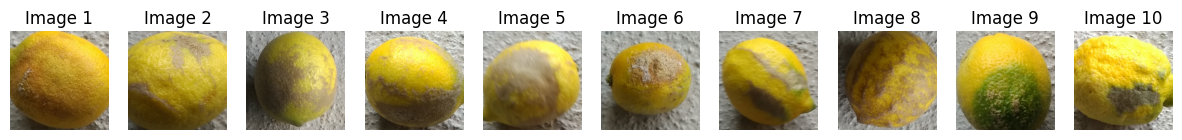

Class: empty_background


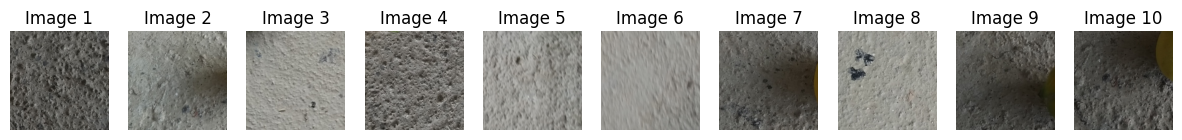

Class: good_quality


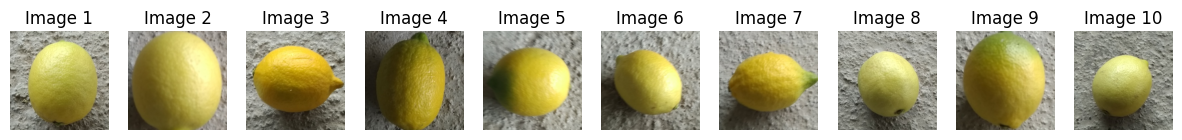

In [5]:
num_images_per_class = 10
classes = dataset.classes

class_images = {cls: [] for cls in classes}

for images, labels in dataloader:
    class_name = classes[labels[0]]
    if len(class_images[class_name]) < num_images_per_class:
        class_images[class_name].append(images[0])

for class_name, images in class_images.items():
    print(f"Class: {class_name}")
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, image in enumerate(images):
        axs[i].imshow(transforms.ToPILImage()(image))
        axs[i].set_title(f"Image {i+1}")
        axs[i].axis('off')
    plt.show()

Se puede observar que el dataset fue cargado correctamente.

Para bad_quality hay 951 samples. Para good_quality hay 1125 samples. Para empty_background hay 453 samples. El dataset esta desbalanceado pero en esta primera instancia no se considerara balancearlo.

En lo que respecta al dataset, se notan algunas caracteristicas: el fondo es siempre el mismo o muy parecido (una especie de cemento rugoso gris o blanco, dependiendo la luz probablemente). La posicion de la luz es cambiante, no siempre viene del mismo lugar. La distancia de la camara al limon tambien es cambiante. Lo mismo sucede para el foco (hay imagenes que hacen mejor foco en el limon y otras que hacen mejor foco en el fondo). Tambien hay imagenes que estan movidas y otras no.

Todas esto lo hace un dataset con mucha variabilidad. Hay pocas posibilidades de que el modelo entrenado ajuste en funcion a estos factores (color del fondo, foco, fuente de la luz, etc). Esto es muy positivo, porque significa que tendra que resolver el problema que verdaderamente es importante, que es el de reconocer el estado de los limones.

Para el armado de modelos y datasets se utilizara Pytorch Lightning, dadas las obvias ventajas de la herramienta (menos boilterplate code, intgraciones sencillas para logging, facil configuracion, entre otras).

In [6]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 150 * 150, 64)  # Adjust input size as needed
        self.fc2 = nn.Linear(64, num_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute training accuracy
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute validation accuracy
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute test accuracy
        preds = torch.argmax(outputs, dim=1)
        accuracy = (preds == labels).float().mean()

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=False)
        self.log('test_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True, logger=True)


In [7]:
# Get the number of classes
num_classes = len(dataset.classes)

# Define the proportions for train, validation, and test splits
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
total_samples = len(dataset)
train_size = int(train_ratio * total_samples)
val_size = int(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

# Perform random splitting
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

# Define PyTorch Lightning DataModules for train, validation, and test
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, val_dataset, test_dataset, batch_size=32):
        super().__init__()
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset
        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# Initialize PyTorch Lightning DataModule
data_module = CustomDataModule(train_dataset, val_dataset, test_dataset)

# Verify the sizes of the splits
print(f"Train set batch size: {len(data_module.train_dataloader())}")
print(f"Validation batch set size: {len(data_module.val_dataloader())}")
print(f"Test batch set size: {len(data_module.test_dataloader())}")

Train set batch size: 56
Validation batch set size: 12
Test batch set size: 12


In [8]:
logger = pl.loggers.CSVLogger("logs", name="lemon_dataset")

trainer = pl.Trainer(max_epochs=10, accelerator="auto", devices="auto", strategy="auto", logger = logger)

model = SimpleCNN(num_classes=len(dataset.classes))
trainer.fit(model, datamodule=data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | conv1     | Conv2d           | 448   
1 | pool      | MaxPool2d        | 0     
2 | fc1       | Linear           | 23.0 M
3 | fc2       | Linear           | 195   
4 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
92.163    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


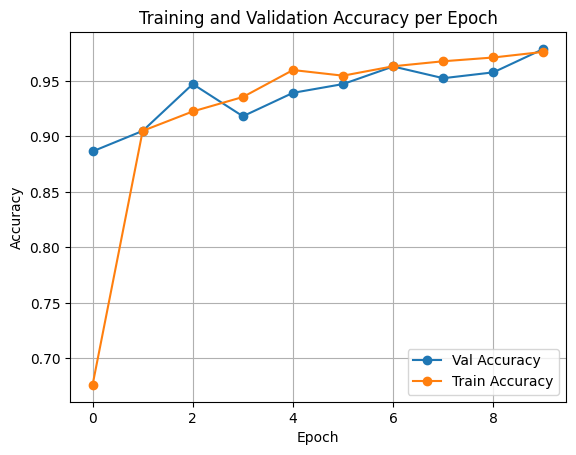

In [9]:
logs = pd.read_csv('./logs/lemon_dataset/version_0/metrics.csv')

plt.plot(range(0, 10), logs['val_accuracy'].dropna(), label='Val Accuracy', marker='o', linestyle='-')
plt.plot(range(0, 10), logs['train_accuracy'].dropna(), label='Train Accuracy', marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
trainer.test(model=model, dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9552631378173828     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9552631378173828}]

Los resultados son muy positivos: en primero lugar la accuracy con el dataset de test fue muy alta, por encime de 0.95. Este ya es un gran indicador de la capacidad del modelo entrenado.

Luego si consideramos las curvas de validacion y entrenamiento de la accuracy el resultado tambien es positivo y acorde a los resultados de test: no pareciera que haya sobreajuste al dataset de training.

En vistas de estos resultados no pareciera muy importante seguir mejorando la performance del modelo. Obviamente se podria mejorar pero la ganancia es marginal en comparación al trabajo que representaria, tanto de pruebas como de tiempo y recursos para el entrenamiento en general.

Ahora se puede probar el modelo con algunas entradas del dataset de test al azar, simplemente para comprobar visualmente los resultado

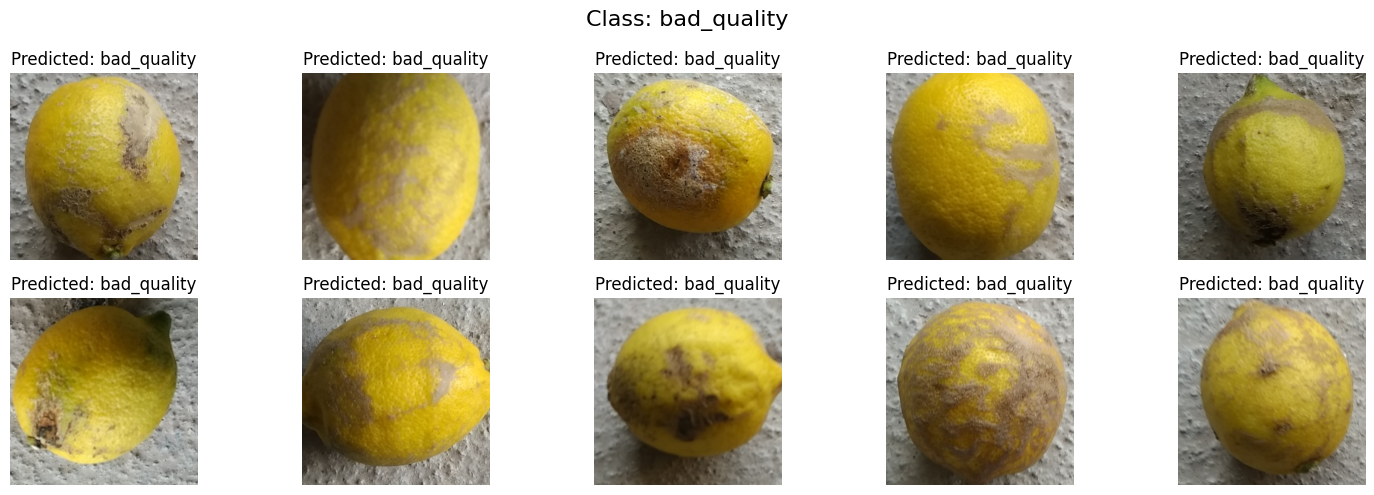

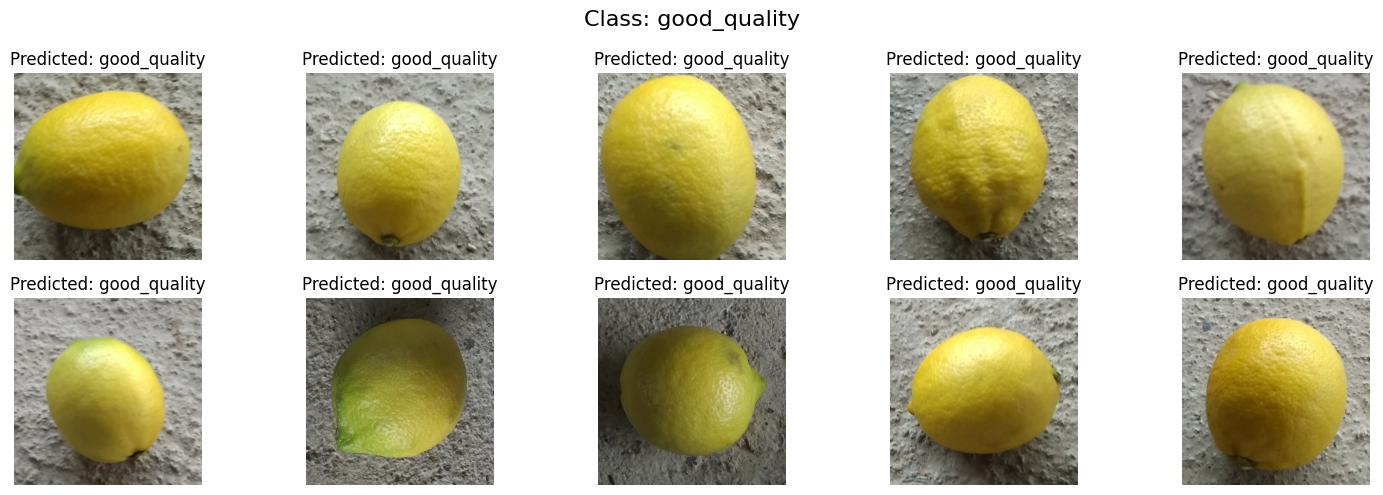

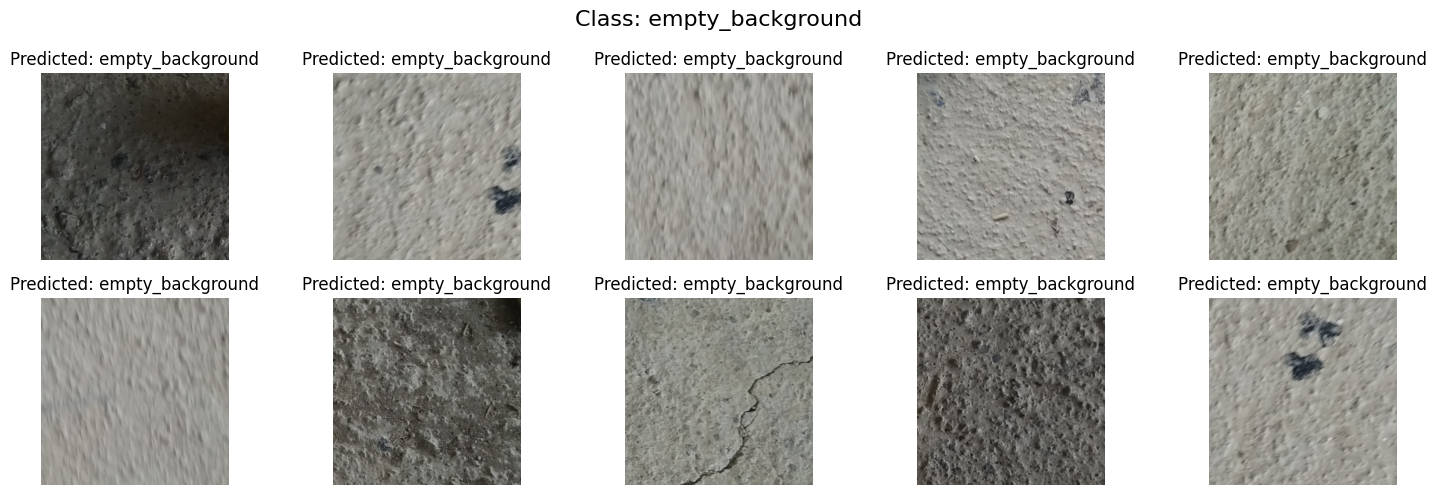

In [45]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

num_images_per_class = 10

images_per_class = {}

test_dataloader = DataLoader(test_dataset, batch_size=1)

with torch.no_grad():
    for image, label in test_dataloader:
        predicted = model(image)
        predicted_class = predicted.argmax(1).item()

        predicted_class_label = dataset.classes[predicted_class]

        current_class_label = dataset.classes[label.item()]

        if current_class_label not in images_per_class:
            images_per_class[current_class_label] = []

        if len(images_per_class[current_class_label]) < num_images_per_class:
            images_per_class[current_class_label].append((image, predicted_class_label))

for class_label, images_and_predictions in images_per_class.items():
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class: {class_label}", fontsize=16)

    for i, (image, predicted_label) in enumerate(images_and_predictions):
        plt.subplot(2, 5, i + 1)
        plt.imshow(transforms.ToPILImage()(image[0]))
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

No hay dudas de que el modelo funciona como se esperaria. Esto lo muestran las metricas y las pruebas manuales. Lo interesante ahora es entender que es lo que esta mirando el modelo para entender a que clase pertenece cada imagen. Como ya se establecio, no hay dudas de que tiene que estar mirando al limon, o a la falta del mismo, y su estado. Para esto se pueden usar tecnicas de explicabilidad. Particularmente se usar GradCAM.

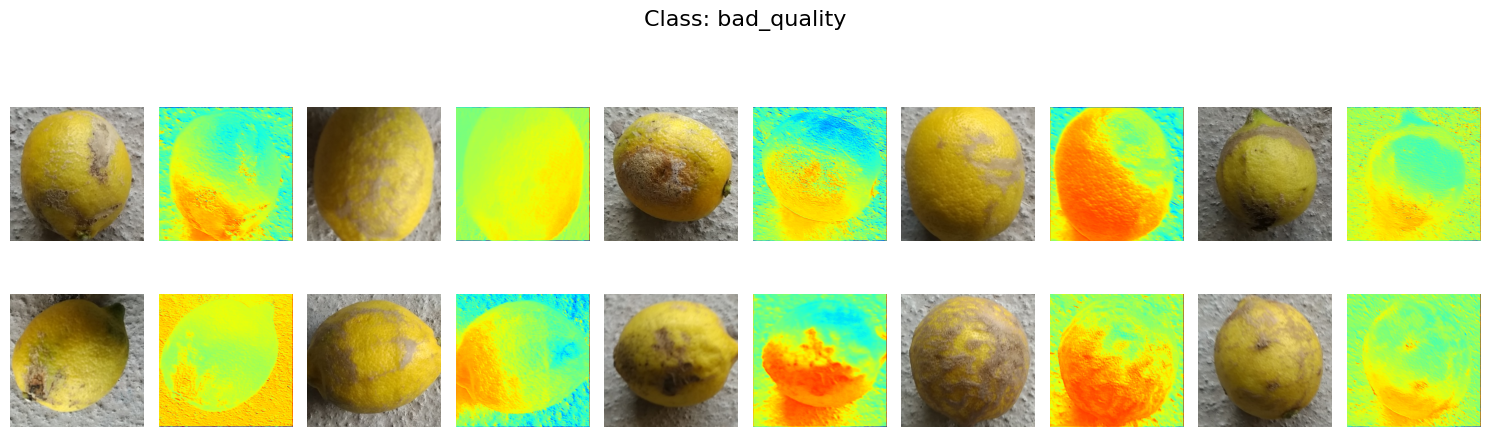

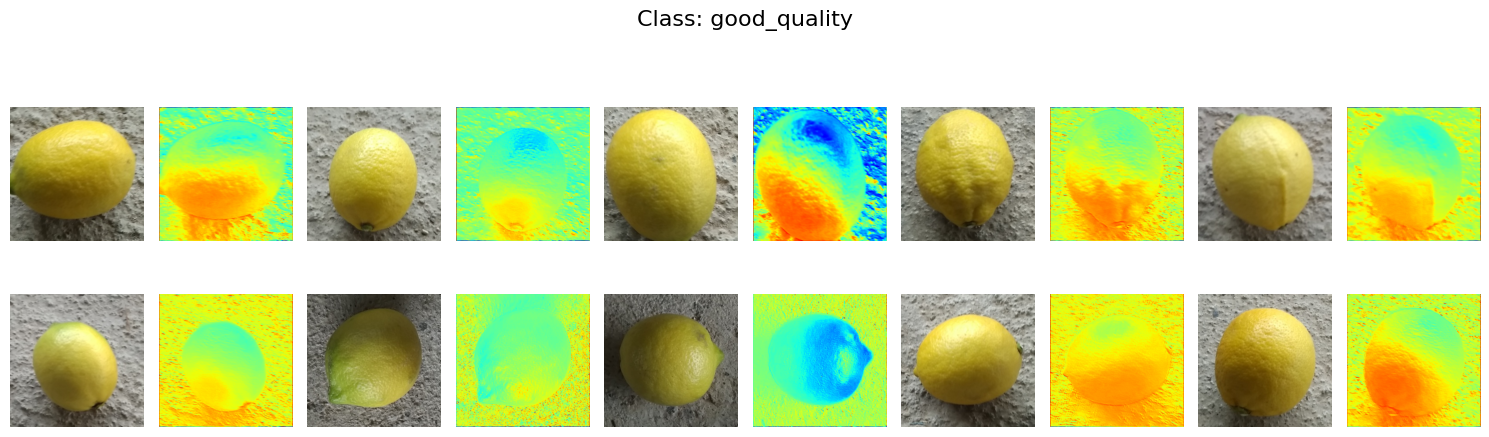

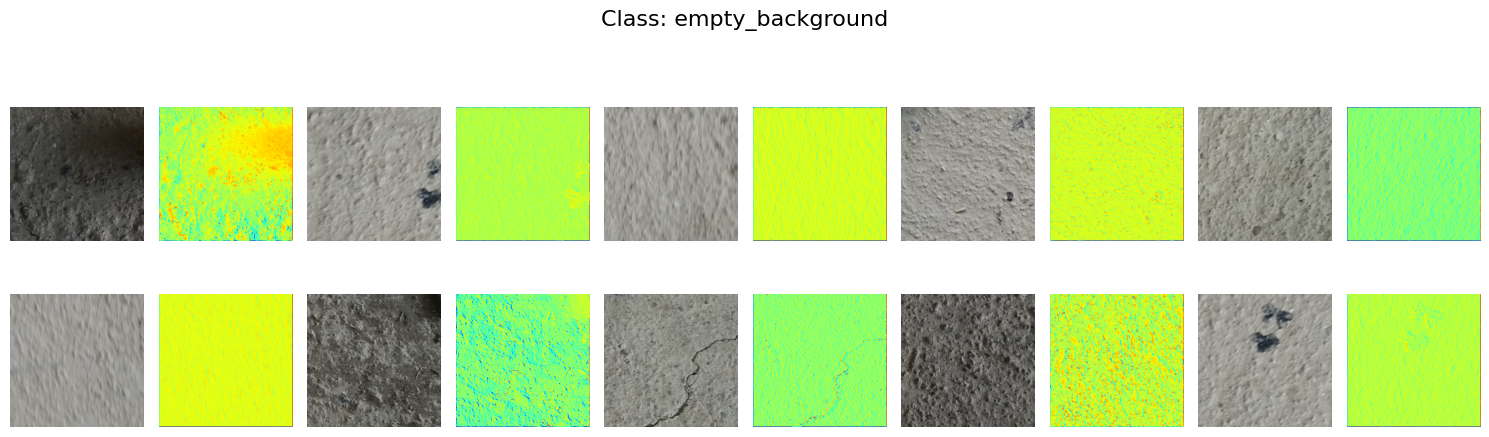

In [55]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import models
from captum.attr import visualization as viz
from captum.attr import LayerGradCam
import cv2
import numpy as np

test_dataloader = DataLoader(test_dataset, batch_size=1)

images_per_class = {}

num_images_per_class = 10

with torch.no_grad():
    for image, label in test_dataloader:
        predicted = model(image)
        predicted_class = predicted.argmax(1).item()

        predicted_class_label = dataset.classes[predicted_class]

        current_class_label = dataset.classes[label.item()]

        if current_class_label not in images_per_class:
            images_per_class[current_class_label] = []

        if len(images_per_class[current_class_label]) < num_images_per_class:
            images_per_class[current_class_label].append((image, predicted_class_label))

gradcam = LayerGradCam(model, model.conv1)  # Adjust the layer as needed

for class_label, images_and_predictions in images_per_class.items():
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Class: {class_label}", fontsize=16)

    for i, (image, predicted_label) in enumerate(images_and_predictions):

        attribution = gradcam.attribute(image, target=predicted_class)

        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min())

        heatmap = attribution[0].cpu().detach().numpy()
        heatmap = (heatmap) / (heatmap.max())

        heatmap = np.uint8(255 * plt.get_cmap('jet')(heatmap)[..., :3])

        overlayed_image = np.transpose(image.squeeze().cpu().numpy(), (1, 2, 0))

        overlayed_image = overlayed_image * heatmap

        plt.subplot(2, 10, i * 2 + 1)
        plt.imshow(image.squeeze().permute(1, 2, 0).numpy())
        plt.axis('off')

        # Plot the heatmap
        plt.subplot(2, 10, i * 2 + 2)
        plt.imshow(heatmap[0], cmap='jet')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Considerando estos resultados se pueden obtener algunas conclusiones:

1) Las partes mas oscuras del limon son las mas relevantes en general para la prediccion. Esto tiene sentido, dado que en los limones sanos la parte mas oscura seguira teniendo un color uniforme y cercano al amarillo. Al mismo tiempo, las partes mas oscuras de la imagen de limones en malas condiciones van a tener colores mas oscuros y mas lejanos de incluso un amarillo apagado: van a ser marrones o negros, o van a tener patrones erraticos entre amarillo y marron.

2) A la hora de deteminar el fondo lo mas importante son los gradientes propios del relieve de la superficie: los bordes de los diferentes grumos son los que marcan que en esa imagen no hay un limon

3) La "logica" que aprende el modelo parece tener sentido y se parece mucho a lo que uno hace naturalmente con la vista. Esto es importante, porque significa que el modelo aprendio de la misma manera que lo haria in humano. Se podria trasladar el modelo a otro escenario o probar con imagenes no pertenecientes al dataset y probablemente seria efectivo.